# Lab 4: Radial Basis Function Classifier

In [1]:
%pylab inline
import numpy
import scipy
from sklearn.datasets import make_blobs
numpy.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

def rotate_xor(centroids_list, angle):
    rotation_matrix = numpy.array(
        [
            [numpy.cos(angle), -numpy.sin(angle)],
            [numpy.sin(angle), numpy.cos(angle)],
        ]
    )
    rotated_centroids = []
    for c in centroids_list:
        _c = numpy.array(c) @ rotation_matrix
        rotated_centroids.append(_c.tolist())
        
    return rotated_centroids

# students, try to shift mean coordinates and check how it changes the performance
n_dim = 2
xor_centroids = [[1,1],[-1,-1],[1,-1],[-1,1]]
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=rotate_xor(xor_centroids, numpy.pi/6), shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=rotate_xor(xor_centroids, numpy.pi/7), shuffle=True, cluster_std=0.4)

# mapping blobs on diagonals belong to the same class

y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

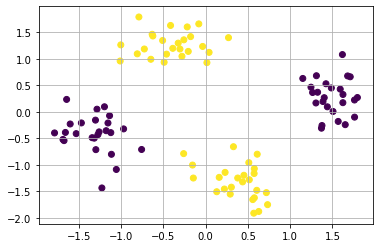

In [3]:
# Plot training data
plt.figure()
plt.scatter(x_tra[:,0], x_tra[:,1], c=y_tra)
plt.grid(True)
plt.show()

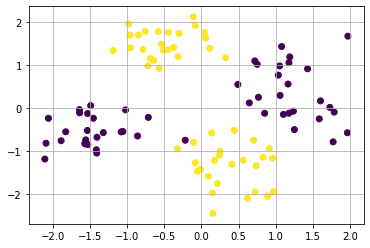

In [4]:
# Plot valid data
plt.figure()
plt.scatter(x_tes[:,0], x_tes[:,1], c=y_tes)
plt.grid(True)
plt.show()

In [5]:
# Install jax if not installed yet:
# !pip install jax
# !pip install jaxlib

import jax.numpy as numpy
from jax import grad, vmap, jit
from jax import random

In [6]:
def rbf_kernel(x, basis, width=1.):
    # q: why we add None in the index operator?
    return numpy.exp(-(((x[:,None,:] - basis[None,:,:]) ** 2).sum(-1) / width))

In [7]:
_x = x_tra[:10]

In [8]:
_basis = _x[0:2]

In [9]:
# basis classes
y_tra[0:2]

array([1, 0])

In [10]:
rbf_kernel(_x, _basis).shape

/Users/owenjones/ML/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(10, 2)

In [11]:
(_x[:,None,:] - _basis[None, :, :])

array([[[ 0.        ,  0.        ],
        [-1.74721572, -1.23970436]],

       [[ 1.74721572,  1.23970436],
        [ 0.        ,  0.        ]],

       [[-1.00026502,  0.41027206],
        [-2.74748073, -0.8294323 ]],

       [[ 1.6302886 ,  0.48017129],
        [-0.11692711, -0.75953307]],

       [[-0.54840604,  1.88400259],
        [-2.29562176,  0.64429823]],

       [[ 0.08216163,  2.20892508],
        [-1.66505408,  0.96922072]],

       [[ 0.39124811, -0.71947933],
        [-1.35596761, -1.95918369]],

       [[ 0.49035016, -0.35432489],
        [-1.25686555, -1.59402925]],

       [[ 0.87041786, -0.01101369],
        [-0.87679785, -1.25071805]],

       [[-1.42716775,  0.26736158],
        [-3.17438347, -0.97234278]]])

In [12]:
projected_tra = rbf_kernel(x_tra, _basis)

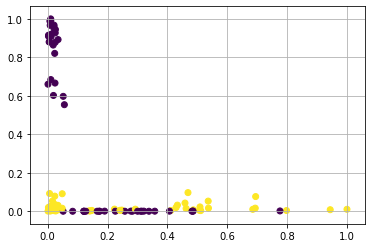

In [13]:
# Plot training data
plt.figure()
plt.scatter(projected_tra[:,0], projected_tra[:,1], c=y_tra)
plt.grid(True)
plt.show()

In [14]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

def logistic_regression(x, w):
    output = x @ w[:-1] + w[-1]
    prob = sigmoid(output)
    
    return prob

In [15]:
x_tra.shape

(100, 2)

In [16]:
logistic_regression(x_tra, numpy.array([0,0,0]))

DeviceArray([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
             0.5, 0.5, 0.5, 0.5], dtype=float32)

In [17]:
NEAR_ZERO = 1e-5

def loss(predicted_probs, targets):
    distance = -(targets * numpy.log(predicted_probs + NEAR_ZERO) + (1 - targets) * numpy.log(1 - predicted_probs + NEAR_ZERO))
    
    return distance

In [18]:
probs = logistic_regression(x_tra, numpy.array([0,0,0]))
loss(probs, y_tra)

DeviceArray([0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.69312716, 0.69312716,
             0.69312716, 0.69312716, 0.69312716, 0.

In [19]:
# for jax, we do a cost function where params will be fed as an argument

def jax_cost(w, x, targets):
    predicted_probs = logistic_regression(x, w)
    per_sample_loss = loss(predicted_probs, targets)
    avg_loss = per_sample_loss.mean()
    
    return avg_loss

grad_jax_cost = jit(vmap(grad(jax_cost, argnums=(0,)), in_axes=(None, 0, 0)))

In [20]:
grad_jax_cost

<function __main__.jit.<locals>.f_jitted(w, x, targets)>

In [21]:
def create_basis(x_tra, num_basis_vectors=4, mode='random'):
    if mode == 'random':
        key = random.PRNGKey(1234)
        num_train = x_tra.shape[0]
        chosen_vectors = random.randint(key, [num_basis_vectors], 0, num_train)
        basis_vectors = numpy.take(x_tra, chosen_vectors, 0)
    else:
        # hard code four clusters given centroids
        basis_vectors = numpy.array(
        [
            [1.,1.],
            [1.,-1.],
            [-1.,-1.],
            [-1.,1.]
        ]
        )
    
    return basis_vectors, num_basis_vectors

In [25]:
from tqdm import tqdm
from jax.ops import index, index_add, index_update

def train_rbfn(x_tra, y_tra, num_basis_vectors=4, rbfn_mode='random', n_iter=1000):

    basis_vectors, num_b = create_basis(x_tra, num_basis_vectors=num_basis_vectors, mode=rbfn_mode)
    key = random.PRNGKey(1234)
    w = 0.01 * random.uniform(key, [num_b + 1])  # why +1?
    w = index_update(w, -1, 0)  # set bias to zero
    
    # Training loop
    eta = .0001   # Learning rate

    cost_log = []
    pbar = tqdm(range(n_iter))

    projected_train = rbf_kernel(x_tra, basis_vectors)  # fixed pre-processing

    for ni in pbar:
        dw, = grad_jax_cost(w, projected_train, y_tra)
        w -= eta * numpy.sum(dw, axis=0)

        cost = numpy.mean(jax_cost(w, projected_train, y_tra))
        cost_log.append(cost)
        pbar.set_description(f"cost: {cost:.5f}")
    
    return basis_vectors, w, cost_log

In [27]:
basis, w, cost_log = train_rbfn(x_tra, y_tra, rbfn_mode='random', num_basis_vectors=16, n_iter=1000)



  0%|          | 0/1000 [00:00<?, ?it/s]

cost: 0.69136:   0%|          | 0/1000 [00:00<?, ?it/s]

cost: 0.69025:   0%|          | 0/1000 [00:00<?, ?it/s]

cost: 0.68915:   0%|          | 0/1000 [00:00<?, ?it/s]

cost: 0.68915:   0%|          | 3/1000 [00:00<00:41, 23.84it/s]

cost: 0.68806:   0%|          | 3/1000 [00:00<00:41, 23.84it/s]

cost: 0.68696:   0%|          | 3/1000 [00:00<00:41, 23.84it/s]

cost: 0.68696:   0%|          | 5/1000 [00:00<00:44, 22.18it/s]

cost: 0.68587:   0%|          | 5/1000 [00:00<00:44, 22.18it/s]

cost: 0.68478:   0%|          | 5/1000 [00:00<00:44, 22.18it/s]

cost: 0.68370:   0%|          | 5/1000 [00:00<00:44, 22.18it/s]

cost: 0.68370:   1%|          | 8/1000 [00:00<00:41, 23.98it/s]

cost: 0.68262:   1%|          | 8/1000 [00:00<00:41, 23.98it/s]

cost: 0.68154:   1%|          | 8/1000 [00:00<00:41, 23.98it/s]

cost: 0.68047:   1%|          | 8/1000 [00:00<00:41, 23.98it/s]

cost: 0.68047:   1%|          | 11/1000 [00:00<00:41, 23.68it/s]

cost

cost: 0.60813:   8%|▊         | 83/1000 [00:03<00:34, 26.94it/s]

cost: 0.60726:   8%|▊         | 83/1000 [00:03<00:34, 26.94it/s]

cost: 0.60726:   9%|▊         | 87/1000 [00:03<00:32, 28.28it/s]

cost: 0.60640:   9%|▊         | 87/1000 [00:03<00:32, 28.28it/s]

cost: 0.60554:   9%|▊         | 87/1000 [00:03<00:32, 28.28it/s]

cost: 0.60468:   9%|▊         | 87/1000 [00:03<00:32, 28.28it/s]

cost: 0.60382:   9%|▊         | 87/1000 [00:03<00:32, 28.28it/s]

cost: 0.60382:   9%|▉         | 91/1000 [00:03<00:31, 29.12it/s]

cost: 0.60297:   9%|▉         | 91/1000 [00:03<00:31, 29.12it/s]

cost: 0.60212:   9%|▉         | 91/1000 [00:03<00:31, 29.12it/s]

cost: 0.60127:   9%|▉         | 91/1000 [00:03<00:31, 29.12it/s]

cost: 0.60042:   9%|▉         | 91/1000 [00:03<00:31, 29.12it/s]

cost: 0.60042:  10%|▉         | 95/1000 [00:03<00:30, 29.89it/s]

cost: 0.59958:  10%|▉         | 95/1000 [00:03<00:30, 29.89it/s]

cost: 0.59874:  10%|▉         | 95/1000 [00:03<00:30, 29.89it/s]

cost: 0.59

cost: 0.54210:  17%|█▋        | 169/1000 [00:07<00:32, 25.27it/s]

cost: 0.54140:  17%|█▋        | 169/1000 [00:07<00:32, 25.27it/s]

cost: 0.54140:  17%|█▋        | 172/1000 [00:07<00:31, 26.09it/s]

cost: 0.54071:  17%|█▋        | 172/1000 [00:07<00:31, 26.09it/s]

cost: 0.54002:  17%|█▋        | 172/1000 [00:07<00:31, 26.09it/s]

cost: 0.53933:  17%|█▋        | 172/1000 [00:07<00:31, 26.09it/s]

cost: 0.53864:  17%|█▋        | 172/1000 [00:07<00:31, 26.09it/s]

cost: 0.53864:  18%|█▊        | 176/1000 [00:07<00:29, 28.10it/s]

cost: 0.53795:  18%|█▊        | 176/1000 [00:07<00:29, 28.10it/s]

cost: 0.53727:  18%|█▊        | 176/1000 [00:07<00:29, 28.10it/s]

cost: 0.53658:  18%|█▊        | 176/1000 [00:07<00:29, 28.10it/s]

cost: 0.53658:  18%|█▊        | 179/1000 [00:07<00:29, 27.37it/s]

cost: 0.53590:  18%|█▊        | 179/1000 [00:07<00:29, 27.37it/s]

cost: 0.53522:  18%|█▊        | 179/1000 [00:07<00:29, 27.37it/s]

cost: 0.53454:  18%|█▊        | 179/1000 [00:07<00:29, 27.37it

cost: 0.48906:  25%|██▌       | 252/1000 [00:10<00:33, 22.27it/s]

cost: 0.48849:  25%|██▌       | 252/1000 [00:10<00:33, 22.27it/s]

cost: 0.48849:  26%|██▌       | 256/1000 [00:10<00:31, 23.79it/s]

cost: 0.48792:  26%|██▌       | 256/1000 [00:10<00:31, 23.79it/s]

cost: 0.48735:  26%|██▌       | 256/1000 [00:10<00:31, 23.79it/s]

cost: 0.48678:  26%|██▌       | 256/1000 [00:10<00:31, 23.79it/s]

cost: 0.48678:  26%|██▌       | 259/1000 [00:10<00:31, 23.88it/s]

cost: 0.48621:  26%|██▌       | 259/1000 [00:10<00:31, 23.88it/s]

cost: 0.48564:  26%|██▌       | 259/1000 [00:10<00:31, 23.88it/s]

cost: 0.48508:  26%|██▌       | 259/1000 [00:10<00:31, 23.88it/s]

cost: 0.48508:  26%|██▌       | 262/1000 [00:10<00:33, 22.03it/s]

cost: 0.48452:  26%|██▌       | 262/1000 [00:10<00:33, 22.03it/s]

cost: 0.48396:  26%|██▌       | 262/1000 [00:10<00:33, 22.03it/s]

cost: 0.48339:  26%|██▌       | 262/1000 [00:10<00:33, 22.03it/s]

cost: 0.48339:  26%|██▋       | 265/1000 [00:10<00:31, 23.28it

cost: 0.44458:  34%|███▎      | 336/1000 [00:13<00:23, 28.38it/s]

cost: 0.44458:  34%|███▍      | 340/1000 [00:13<00:22, 28.71it/s]

cost: 0.44410:  34%|███▍      | 340/1000 [00:14<00:22, 28.71it/s]

cost: 0.44362:  34%|███▍      | 340/1000 [00:14<00:22, 28.71it/s]

cost: 0.44315:  34%|███▍      | 340/1000 [00:14<00:22, 28.71it/s]

cost: 0.44315:  34%|███▍      | 343/1000 [00:14<00:23, 28.48it/s]

cost: 0.44267:  34%|███▍      | 343/1000 [00:14<00:23, 28.48it/s]

cost: 0.44220:  34%|███▍      | 343/1000 [00:14<00:23, 28.48it/s]

cost: 0.44173:  34%|███▍      | 343/1000 [00:14<00:23, 28.48it/s]

cost: 0.44173:  35%|███▍      | 346/1000 [00:14<00:22, 28.81it/s]

cost: 0.44125:  35%|███▍      | 346/1000 [00:14<00:22, 28.81it/s]

cost: 0.44078:  35%|███▍      | 346/1000 [00:14<00:22, 28.81it/s]

cost: 0.44031:  35%|███▍      | 346/1000 [00:14<00:22, 28.81it/s]

cost: 0.44031:  35%|███▍      | 349/1000 [00:14<00:22, 28.31it/s]

cost: 0.43984:  35%|███▍      | 349/1000 [00:14<00:22, 28.31it

cost: 0.40758:  42%|████▏     | 423/1000 [00:17<00:22, 25.51it/s]

cost: 0.40717:  42%|████▏     | 423/1000 [00:17<00:22, 25.51it/s]

cost: 0.40677:  42%|████▏     | 423/1000 [00:17<00:22, 25.51it/s]

cost: 0.40636:  42%|████▏     | 423/1000 [00:17<00:22, 25.51it/s]

cost: 0.40636:  43%|████▎     | 427/1000 [00:17<00:21, 26.99it/s]

cost: 0.40596:  43%|████▎     | 427/1000 [00:17<00:21, 26.99it/s]

cost: 0.40556:  43%|████▎     | 427/1000 [00:17<00:21, 26.99it/s]

cost: 0.40516:  43%|████▎     | 427/1000 [00:17<00:21, 26.99it/s]

cost: 0.40516:  43%|████▎     | 430/1000 [00:17<00:20, 27.72it/s]

cost: 0.40476:  43%|████▎     | 430/1000 [00:17<00:20, 27.72it/s]

cost: 0.40436:  43%|████▎     | 430/1000 [00:17<00:20, 27.72it/s]

cost: 0.40396:  43%|████▎     | 430/1000 [00:17<00:20, 27.72it/s]

cost: 0.40396:  43%|████▎     | 433/1000 [00:17<00:21, 26.46it/s]

cost: 0.40356:  43%|████▎     | 433/1000 [00:17<00:21, 26.46it/s]

cost: 0.40316:  43%|████▎     | 433/1000 [00:17<00:21, 26.46it

cost: 0.37530:  51%|█████     | 507/1000 [00:21<00:22, 22.26it/s]

cost: 0.37530:  51%|█████     | 510/1000 [00:21<00:22, 21.65it/s]

cost: 0.37496:  51%|█████     | 510/1000 [00:21<00:22, 21.65it/s]

cost: 0.37461:  51%|█████     | 510/1000 [00:21<00:22, 21.65it/s]

cost: 0.37426:  51%|█████     | 510/1000 [00:21<00:22, 21.65it/s]

cost: 0.37426:  51%|█████▏    | 513/1000 [00:21<00:22, 21.61it/s]

cost: 0.37392:  51%|█████▏    | 513/1000 [00:21<00:22, 21.61it/s]

cost: 0.37358:  51%|█████▏    | 513/1000 [00:21<00:22, 21.61it/s]

cost: 0.37323:  51%|█████▏    | 513/1000 [00:21<00:22, 21.61it/s]

cost: 0.37323:  52%|█████▏    | 516/1000 [00:21<00:25, 19.33it/s]

cost: 0.37289:  52%|█████▏    | 516/1000 [00:21<00:25, 19.33it/s]

cost: 0.37255:  52%|█████▏    | 516/1000 [00:21<00:25, 19.33it/s]

cost: 0.37220:  52%|█████▏    | 516/1000 [00:21<00:25, 19.33it/s]

cost: 0.37220:  52%|█████▏    | 519/1000 [00:21<00:26, 18.31it/s]

cost: 0.37186:  52%|█████▏    | 519/1000 [00:21<00:26, 18.31it

cost: 0.34875:  59%|█████▉    | 591/1000 [00:24<00:13, 31.45it/s]

cost: 0.34845:  59%|█████▉    | 591/1000 [00:24<00:13, 31.45it/s]

cost: 0.34815:  59%|█████▉    | 591/1000 [00:24<00:13, 31.45it/s]

cost: 0.34785:  59%|█████▉    | 591/1000 [00:24<00:13, 31.45it/s]

cost: 0.34785:  60%|█████▉    | 595/1000 [00:24<00:12, 31.50it/s]

cost: 0.34755:  60%|█████▉    | 595/1000 [00:24<00:12, 31.50it/s]

cost: 0.34725:  60%|█████▉    | 595/1000 [00:24<00:12, 31.50it/s]

cost: 0.34695:  60%|█████▉    | 595/1000 [00:24<00:12, 31.50it/s]

cost: 0.34665:  60%|█████▉    | 595/1000 [00:24<00:12, 31.50it/s]

cost: 0.34665:  60%|█████▉    | 599/1000 [00:24<00:12, 32.43it/s]

cost: 0.34635:  60%|█████▉    | 599/1000 [00:24<00:12, 32.43it/s]

cost: 0.34605:  60%|█████▉    | 599/1000 [00:24<00:12, 32.43it/s]

cost: 0.34576:  60%|█████▉    | 599/1000 [00:24<00:12, 32.43it/s]

cost: 0.34546:  60%|█████▉    | 599/1000 [00:24<00:12, 32.43it/s]

cost: 0.34546:  60%|██████    | 603/1000 [00:24<00:12, 31.96it

cost: 0.32397:  68%|██████▊   | 680/1000 [00:27<00:10, 30.47it/s]

cost: 0.32371:  68%|██████▊   | 680/1000 [00:27<00:10, 30.47it/s]

cost: 0.32345:  68%|██████▊   | 680/1000 [00:27<00:10, 30.47it/s]

cost: 0.32318:  68%|██████▊   | 680/1000 [00:27<00:10, 30.47it/s]

cost: 0.32292:  68%|██████▊   | 680/1000 [00:27<00:10, 30.47it/s]

cost: 0.32292:  68%|██████▊   | 684/1000 [00:27<00:10, 30.45it/s]

cost: 0.32266:  68%|██████▊   | 684/1000 [00:27<00:10, 30.45it/s]

cost: 0.32240:  68%|██████▊   | 684/1000 [00:27<00:10, 30.45it/s]

cost: 0.32214:  68%|██████▊   | 684/1000 [00:27<00:10, 30.45it/s]

cost: 0.32188:  68%|██████▊   | 684/1000 [00:27<00:10, 30.45it/s]

cost: 0.32188:  69%|██████▉   | 688/1000 [00:27<00:09, 31.63it/s]

cost: 0.32162:  69%|██████▉   | 688/1000 [00:27<00:09, 31.63it/s]

cost: 0.32136:  69%|██████▉   | 688/1000 [00:27<00:09, 31.63it/s]

cost: 0.32111:  69%|██████▉   | 688/1000 [00:27<00:09, 31.63it/s]

cost: 0.32085:  69%|██████▉   | 688/1000 [00:27<00:09, 31.63it

cost: 0.30234:  77%|███████▋  | 768/1000 [00:30<00:07, 30.14it/s]

cost: 0.30211:  77%|███████▋  | 768/1000 [00:30<00:07, 30.14it/s]

cost: 0.30188:  77%|███████▋  | 768/1000 [00:30<00:07, 30.14it/s]

cost: 0.30165:  77%|███████▋  | 768/1000 [00:30<00:07, 30.14it/s]

cost: 0.30142:  77%|███████▋  | 768/1000 [00:30<00:07, 30.14it/s]

cost: 0.30142:  77%|███████▋  | 772/1000 [00:30<00:07, 28.82it/s]

cost: 0.30119:  77%|███████▋  | 772/1000 [00:30<00:07, 28.82it/s]

cost: 0.30097:  77%|███████▋  | 772/1000 [00:30<00:07, 28.82it/s]

cost: 0.30074:  77%|███████▋  | 772/1000 [00:30<00:07, 28.82it/s]

cost: 0.30074:  78%|███████▊  | 775/1000 [00:30<00:08, 26.42it/s]

cost: 0.30051:  78%|███████▊  | 775/1000 [00:30<00:08, 26.42it/s]

cost: 0.30028:  78%|███████▊  | 775/1000 [00:31<00:08, 26.42it/s]

cost: 0.30006:  78%|███████▊  | 775/1000 [00:31<00:08, 26.42it/s]

cost: 0.30006:  78%|███████▊  | 778/1000 [00:31<00:08, 25.07it/s]

cost: 0.29983:  78%|███████▊  | 778/1000 [00:31<00:08, 25.07it

cost: 0.28352:  85%|████████▌ | 852/1000 [00:33<00:04, 29.80it/s]

cost: 0.28331:  85%|████████▌ | 852/1000 [00:33<00:04, 29.80it/s]

cost: 0.28331:  86%|████████▌ | 856/1000 [00:33<00:04, 30.91it/s]

cost: 0.28311:  86%|████████▌ | 856/1000 [00:33<00:04, 30.91it/s]

cost: 0.28291:  86%|████████▌ | 856/1000 [00:33<00:04, 30.91it/s]

cost: 0.28270:  86%|████████▌ | 856/1000 [00:33<00:04, 30.91it/s]

cost: 0.28250:  86%|████████▌ | 856/1000 [00:33<00:04, 30.91it/s]

cost: 0.28250:  86%|████████▌ | 860/1000 [00:33<00:04, 31.88it/s]

cost: 0.28230:  86%|████████▌ | 860/1000 [00:33<00:04, 31.88it/s]

cost: 0.28210:  86%|████████▌ | 860/1000 [00:34<00:04, 31.88it/s]

cost: 0.28190:  86%|████████▌ | 860/1000 [00:34<00:04, 31.88it/s]

cost: 0.28170:  86%|████████▌ | 860/1000 [00:34<00:04, 31.88it/s]

cost: 0.28170:  86%|████████▋ | 864/1000 [00:34<00:04, 31.48it/s]

cost: 0.28150:  86%|████████▋ | 864/1000 [00:34<00:04, 31.48it/s]

cost: 0.28130:  86%|████████▋ | 864/1000 [00:34<00:04, 31.48it

cost: 0.26700:  94%|█████████▍| 939/1000 [00:37<00:02, 28.73it/s]

cost: 0.26682:  94%|█████████▍| 939/1000 [00:37<00:02, 28.73it/s]

cost: 0.26682:  94%|█████████▍| 942/1000 [00:37<00:02, 23.72it/s]

cost: 0.26664:  94%|█████████▍| 942/1000 [00:37<00:02, 23.72it/s]

cost: 0.26646:  94%|█████████▍| 942/1000 [00:37<00:02, 23.72it/s]

cost: 0.26628:  94%|█████████▍| 942/1000 [00:37<00:02, 23.72it/s]

cost: 0.26628:  94%|█████████▍| 945/1000 [00:37<00:02, 24.26it/s]

cost: 0.26610:  94%|█████████▍| 945/1000 [00:37<00:02, 24.26it/s]

cost: 0.26592:  94%|█████████▍| 945/1000 [00:37<00:02, 24.26it/s]

cost: 0.26574:  94%|█████████▍| 945/1000 [00:37<00:02, 24.26it/s]

cost: 0.26556:  94%|█████████▍| 945/1000 [00:37<00:02, 24.26it/s]

cost: 0.26556:  95%|█████████▍| 949/1000 [00:37<00:02, 25.49it/s]

cost: 0.26538:  95%|█████████▍| 949/1000 [00:37<00:02, 25.49it/s]

cost: 0.26520:  95%|█████████▍| 949/1000 [00:37<00:02, 25.49it/s]

cost: 0.26502:  95%|█████████▍| 949/1000 [00:37<00:02, 25.49it

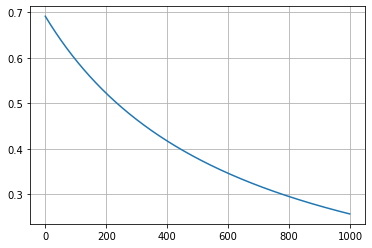

In [28]:
# Plot cost over training iterations
plt.figure()
plt.plot(cost_log)
plt.grid(True)
plt.show()

In [29]:
# Function returning labels from the logit
def get_label_from_logit(logits):
    results = [0 if i < 0.5 else 1 for i in logits]    
    return results

def get_rbfn_output(x, basis, w):
    projected_input = rbf_kernel(x, basis)
    return logistic_regression(projected_input, w)

train_predictions = get_label_from_logit(get_rbfn_output(x_tra, basis, w))
val_predictions = get_label_from_logit(get_rbfn_output(x_tes, basis, w))

In [30]:
print('Training accuracy {:2}'.format(numpy.sum(train_predictions == y_tra)/len(y_tra)))
print('Validation accuracy {:2}'.format(numpy.sum(val_predictions == y_tes)/len(y_tes)))

Training accuracy 1.0
Validation accuracy 0.949999988079071


In [31]:
basis

DeviceArray([[ 1.6185278 ,  1.0833136 ],
             [ 0.1611602 , -1.2351481 ],
             [ 1.3707343 , -0.30678007],
             [-1.6743805 , -0.54144084],
             [-1.2267077 , -1.4350804 ],
             [ 1.507456  ,  0.0087327 ],
             [-1.1547569 , -0.20897302],
             [-1.6743805 , -0.54144084],
             [ 0.45338702, -1.1960653 ],
             [ 0.04131377,  1.1245753 ],
             [-1.2598193 , -0.3766793 ],
             [-1.5304981 , -0.40941125],
             [-1.7866174 , -0.39630085],
             [ 0.5702222 , -1.9115751 ],
             [ 0.04131377,  1.1245753 ],
             [-0.21718253,  1.6050038 ]], dtype=float32)

In [ ]:
def vis_decision_boundary(w, basis, typ='k--'):

    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    _input_data = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    pred = get_rbfn_output(_input_data, basis, w)
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.4)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

In [ ]:
def plot_data_and_boundary(data, labels, basis, w):
    plt.figure()
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.scatter(basis[:,0], basis[:,1], marker='x', c='red')
    plt.grid(True)
    vis_decision_boundary(w, basis)

In [ ]:
plot_data_and_boundary(x_tra, y_tra, basis, w)

In [ ]:
plot_data_and_boundary(x_tes, y_tes, basis, w)

## Going to adaptive basis ...

In [ ]:
# redefine rbf kernel for single sample to use with vmap
def rbf_kernel(x, basis, width=1.):
    # q: why we add None in the index operator?
    if x.ndim == 1:
        return numpy.exp(-(((x[None,:] - basis) ** 2).sum(-1) / width))
    else:
        return numpy.exp(-(((x[:,None,:] - basis[None,:,:]) ** 2).sum(-1) / width))

In [ ]:
def jax_abf_cost(w, basis, x, targets):
    # we compute features every time now!
    projected_input = rbf_kernel(x, basis)
    
    predicted_probs = logistic_regression(projected_input, w)
    per_sample_loss = loss(predicted_probs, targets)
    avg_loss = per_sample_loss.mean()
    
    return avg_loss

In [ ]:
grad_jax_abf_cost = vmap(grad(jax_abf_cost, argnums=(0,1,)), in_axes=(None, None, 0, 0))

In [ ]:
def train_abf(x_tra, y_tra, num_basis_vectors=4, n_iter=10000):
    key = random.PRNGKey(12345)
    basis_vectors, num_b = create_basis(x_tra, num_basis_vectors=num_basis_vectors, mode='random')
    
    w = 0.0001 * random.uniform(key, [num_b + 1])  # why +1?
    w = index_update(w, -1, 0)  # set bias to zero
    
    # Training loop
    eta = .001   # Learning rate

    cost_log = []
    pbar = tqdm(range(n_iter))

    for ni in pbar:
        dw, dbasis = grad_jax_abf_cost(w, basis_vectors, x_tra, y_tra)
        w -= eta * numpy.sum(dw, axis=0)
        basis_vectors -= eta * numpy.sum(dbasis, axis=0)

        cost = numpy.mean(jax_abf_cost(w, basis_vectors, x_tra, y_tra))
        cost_log.append(cost)
        pbar.set_description(f"cost: {cost:.5f}")
    
    return basis_vectors, w, cost_log

In [ ]:
tqdm._instances.clear()
basis, w, cost_log = train_abf(x_tra, y_tra, n_iter=5000)

In [ ]:
basis

In [ ]:
plot_data_and_boundary(x_tra, y_tra, basis, w)

In [ ]:
plot_data_and_boundary(x_tes, y_tes, basis, w)

In [ ]:
train_predictions = get_label_from_logit(get_rbfn_output(x_tra, basis, w))
val_predictions = get_label_from_logit(get_rbfn_output(x_tes, basis, w))
print('Training accuracy {:2}'.format(numpy.sum(train_predictions == y_tra)/len(y_tra)))
print('Validation accuracy {:2}'.format(numpy.sum(val_predictions == y_tes)/len(y_tes)))

## Making a MLP: adding a hidden layer with a non-linearity

In [ ]:
def jax_mlp_cost(w2, w1, x, targets):
    # hidden non-linear layer!
    projected_input = sigmoid(x @ w1[:-1, :] + w1[-1])
    
    predicted_probs = logistic_regression(projected_input, w2)
    per_sample_loss = loss(predicted_probs, targets)
    avg_loss = per_sample_loss.mean()
    
    return avg_loss

grad_jax_mlp_cost = jit(vmap(grad(jax_mlp_cost, argnums=(0,1,)), in_axes=(None, None, 0, 0)))

def train_mlp(x_tra, y_tra, num_basis_vectors=4, n_iter=10000):
    key = random.PRNGKey(12345)
    num_b = num_basis_vectors
    # effectively this is weights of hidden layer now
    basis_vectors = 0.01 * random.uniform(key, [2 + 1, num_b])
    
    w = 0.0001 * random.uniform(key, [num_b + 1])  # why +1?
    w = index_update(w, -1, 0)  # set bias to zero
    
    # Training loop
    eta = .01   # Learning rate

    cost_log = []
    pbar = tqdm(range(n_iter))

    for ni in pbar:
        dw, dbasis = grad_jax_mlp_cost(w, basis_vectors, x_tra, y_tra)
        w -= eta * numpy.sum(dw, axis=0)
        basis_vectors -= eta *100* numpy.sum(dbasis, axis=0)

        cost = numpy.mean(jax_mlp_cost(w, basis_vectors, x_tra, y_tra))
        cost_log.append(cost)
        pbar.set_description(f"cost: {cost:.5f}")
    
    return basis_vectors, w, cost_log

In [ ]:
tqdm._instances.clear()
basis, w, cost_log = train_mlp(x_tra, y_tra, n_iter=5000)

In [ ]:
# Plot cost over training iterations
plt.figure()
plt.plot(cost_log)
plt.grid(True)
plt.show()

In [ ]:
def vis_decision_boundary_adaptive(w2, w1, typ='k--'):

    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    _input_data = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    projected_input = sigmoid(_input_data @ w1[:-1, :] + w1[-1])
    predicted_probs = logistic_regression(projected_input, w2)
    
    pred = predicted_probs
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.4)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

plt.figure()
plt.scatter(x_tra[:,0], x_tra[:,1], c=y_tra)
plt.grid(True)
vis_decision_boundary_adaptive(w, basis)

In [ ]:
def get_mlp_output(data, w1, w2):
    projected_input = sigmoid(data @ w1[:-1, :] + w1[-1])
    predicted_probs = logistic_regression(projected_input, w2)
    return predicted_probs

train_predictions = get_label_from_logit(get_mlp_output(x_tra, basis, w))
val_predictions = get_label_from_logit(get_mlp_output(x_tes, basis, w))
print('Training accuracy {:2}'.format(numpy.sum(train_predictions == y_tra)/len(y_tra)))
print('Validation accuracy {:2}'.format(numpy.sum(val_predictions == y_tes)/len(y_tes)))